In [1246]:
# Load dependencies
import pandas as pd
import numpy as np

import seaborn as sns

# Perform multiple imputation for missing values 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# Train / Test split
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [1247]:
dfs = pd.read_csv('/Users/Apple/Downloads/ALS_Digital_Twins/All_processed_data/combined_other_datasets_for_modeling.csv')
df = dfs.copy()
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [1248]:
df.shape

(1678, 13)

In [1249]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt'],
      dtype='object')

In [1250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB


In [1251]:
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Study_id: {'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}


In [1252]:
df = df[df['Expt'] != 'riluzole']
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

df.shape

Expt: {'mirocals': 220, 'licals': 176}

Study_id: {'miro': 220, 'lica': 176}


(396, 13)

In [1253]:
df['Agec'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['TRICALSc'] = (df['TRICALS'] - df['TRICALS'].mean()) / df['TRICALS'].std()

In [1254]:
df_time = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time.describe()
# df_time.isna().sum()

,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,396.000000,396.000000,396.000000
mean,29.773236,12.600114,93.606061
std,8.569203,5.929346,17.016042
min,8.051348,0.984000,60.000000
25%,24.530716,7.923000,80.000000
50%,31.473046,12.481527,92.000000
75%,36.177070,16.962729,104.000000
max,50.636005,31.767411,139.000000


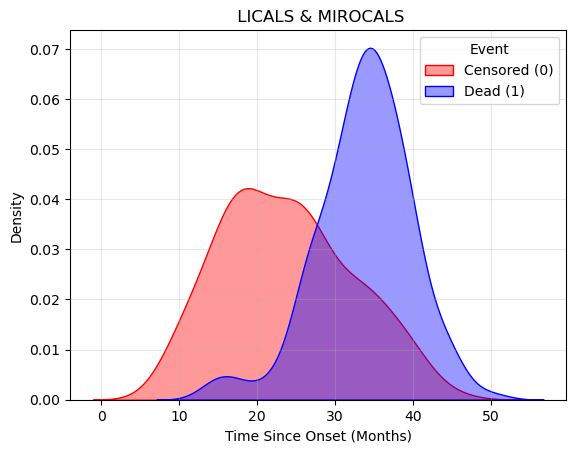

<Figure size 400x300 with 0 Axes>

In [1255]:
# Plot distribution of survival time for both groups
sns.kdeplot(
    data=df, x="Disease_Duration", hue="Event",
    fill=True, common_norm=False, alpha=0.4,
    palette={1: "red", 0: "blue"},
);

plt.xlabel("Time Since Onset (Months)")
plt.ylabel("Density")
plt.title(" LICALS & MIROCALS")
plt.legend(title="Event", labels=["Censored (0)", "Dead (1)"])
plt.grid(alpha=0.3)
plt.show();

plt.figure(figsize=(4,3));

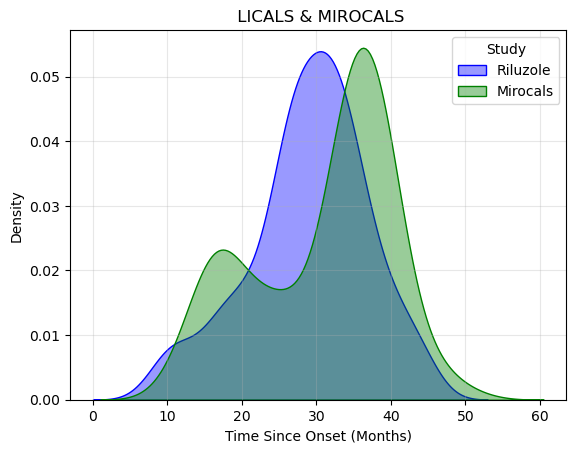

<Figure size 400x300 with 0 Axes>

In [1256]:
# Plot distribution of survival time for both groups
sns.kdeplot(
    data=df, x="Disease_Duration", hue="Expt",
    fill=True, common_norm=False, alpha=0.4,
    palette={'riluzole': "red", 'mirocals': "blue" , 'licals': "green"},
);

plt.xlabel("Time Since Onset (Months)")
plt.ylabel("Density")
plt.title(" LICALS & MIROCALS")
plt.legend(title="Study", labels=['Riluzole', 'Mirocals', 'Licals'])
plt.grid(alpha=0.3)
plt.show();

plt.figure(figsize=(4,3));

In [1257]:
df['Disease_Durationc'] = np.log1p(df['Disease_Duration']) # ln(1 + x)
df['Diagnostic_Delayc'] = np.log1p(df['Diagnostic_Delay']) # ln(1 + x)
df['Vital_capacityc'] = np.log(df['Vital_capacity']) # ln(x)

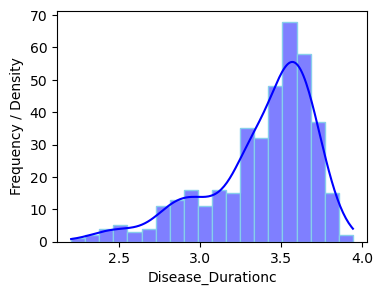

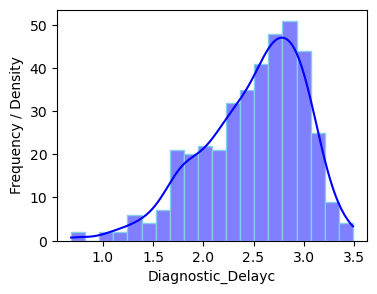

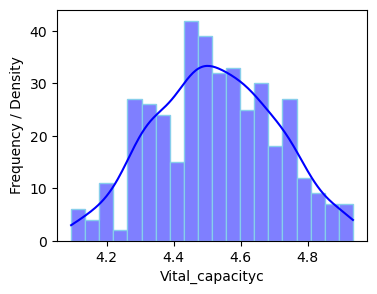

In [1258]:
df_time = df[['Disease_Durationc', 'Diagnostic_Delayc', 'Vital_capacityc']]
df_time.describe()

import seaborn as sns
# Plot histogram and density
for col in df_time.columns:
    plt.figure(figsize=(4,3))
    sns.histplot(df[col], bins=20, kde=True, color='blue', edgecolor='skyblue')
    plt.ylabel('Frequency / Density')
    plt.show()

In [1259]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt', 'Agec', 'TRICALSc', 'Disease_Durationc',
       'Diagnostic_Delayc', 'Vital_capacityc'],
      dtype='object')

In [1260]:
df['European'] = df['European'].astype('int')
df['Event'] = df['Event'].astype('int')

In [1261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         396 non-null    object 
 1   Event              396 non-null    int64  
 2   Vital_capacity     396 non-null    float64
 3   Sex                396 non-null    object 
 4   Onset_site         396 non-null    object 
 5   Study_Arm          396 non-null    object 
 6   European           396 non-null    int64  
 7   Age                396 non-null    float64
 8   Diagnostic_Delay   396 non-null    float64
 9   Disease_Duration   396 non-null    float64
 10  TRICALS            396 non-null    float64
 11  Study_id           396 non-null    object 
 12  Expt               396 non-null    object 
 13  Agec               396 non-null    float64
 14  TRICALSc           396 non-null    float64
 15  Disease_Durationc  396 non-null    float64
 16  Diagnostic_Delayc  396 non-null

In [1262]:
print(df.shape)
df.head(3)

(396, 18)


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc
0,P01001,0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829
1,P01002,1,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120
2,P01003,0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973


In [1263]:
print(f'Event: {df['Event'].value_counts().to_dict()}\n')
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Event: {0: 240, 1: 156}

Expt: {'mirocals': 220, 'licals': 176}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 392, 0: 4}



In [1264]:
mapping = {'Limb': 1, 'Bulbar': 0, 'Other': 1, '1.0': 1,
           '0.0': 0, '2.0': 0, 1.0: 1, 0.0: 0}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 1, 'F': 0, 'Male': 1,'Female': 0, '1': 1, '0': 0}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 1, 1, 0)

In [1265]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'mirocals': 220, 'licals': 176}

Onset_site: {1: 319, 0: 77}

Sex: {1: 262, 0: 134}

Study_Arm: {'Active': 199, 'Placebo': 197}

European: {1: 392, 0: 4}



In [1266]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex']  # replace with your actual categorical columns

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [1267]:
df_onehot.head(3)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1
0,P01001,0,107.0,Placebo,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,True,True,True
1,P01002,1,99.0,Placebo,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,True,True,False
2,P01003,0,102.0,Active,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,True,True,True


In [1268]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1'],
      dtype='object')

In [1269]:
# Convert one-hot encoded columns to int
df_onehot['Onset_site_1'] = df_onehot['Onset_site_1'].astype(int)
df_onehot['European_1'] = df_onehot['European_1'].astype(int)
df_onehot['Sex_1'] = df_onehot['Sex_1'].astype(int)

In [1270]:
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1
0,P01001,0,107.0,Placebo,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,1,1,1
1,P01002,1,99.0,Placebo,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1,1,0


In [1271]:
# Create interactions
df_onehot['Sex (Male) : onset (Limb)'] = df_onehot['Sex_1']*df_onehot['Onset_site_1']
df_onehot['Sex (Male) : Age'] = df_onehot['Sex_1']*df_onehot['Age']
df_onehot['Age : onset (Limb)'] = df_onehot['Age']*df_onehot['Onset_site_1']
df_onehot['Age : TRICALS'] = df_onehot['Age']*df_onehot['TRICALS']
# df_onehot['Trical_Study_Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

In [1272]:
df_onehot.head(3)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1,Sex (Male) : onset (Limb),Sex (Male) : Age,Age : onset (Limb),Age : TRICALS
0,P01001,0,107.0,Placebo,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,1,1,1,1,54.762491,54.762491,-269.505759
1,P01002,1,99.0,Placebo,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1,1,0,0,0.000000,61.160849,-388.189012
2,P01003,0,102.0,Active,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,1,1,1,1,46.702259,46.702259,-297.673270


In [1273]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 396 non-null    object 
 1   Event                      396 non-null    int64  
 2   Vital_capacity             396 non-null    float64
 3   Study_Arm                  396 non-null    object 
 4   Age                        396 non-null    float64
 5   Diagnostic_Delay           396 non-null    float64
 6   Disease_Duration           396 non-null    float64
 7   TRICALS                    396 non-null    float64
 8   Study_id                   396 non-null    object 
 9   Expt                       396 non-null    object 
 10  Agec                       396 non-null    float64
 11  TRICALSc                   396 non-null    float64
 12  Disease_Durationc          396 non-null    float64
 13  Diagnostic_Delayc          396 non-null    float64
 14 

| **Variable Type**             | **Role in Survival Analysis**               | **Data Type in Python**                                      | **Example**                        | **Typical Preprocessing**                                                                  |
| ----------------------------- | ------------------------------------------- | ------------------------------------------------------------ | ---------------------------------- | ------------------------------------------------------------------------------------------ |
| **Time** (duration)           | Time from start point to event or censoring | `int` or `float` (non-negative)                              | `5, 10.2, 7`                       | Ensure numeric, non-negative; convert units if needed                                      |
| **Event Indicator** (status)  | 1 if event occurred, 0 if censored          | `int` (`0/1`) or `bool`                                      | `1, 0, 1, 0`                       | Convert booleans to integers if required by library                                        |
| **Numeric Covariates**        | Continuous predictors                       | `int` or `float`                                             | `age = 65`, `bp = 120`             | Scale/normalize if desired                                                                 |
| **Categorical Covariates**    | Discrete categories                         | `object` or `category`                                       | `sex = 'male', 'female'`           | Convert to dummy variables with `pd.get_dummies()`                                         |
| **Binary Covariates**         | Yes/No predictors                           | `int` (`0/1`) or `bool`                                      | `smoker = 1`                       | Ensure proper encoding (0/1)                                                               |
| **Time-dependent Covariates** | Variables that change over time             | Structured in **long format** with multiple rows per subject | Weight measurements over follow-up | Reshape dataset; specialized survival functions (`add_covariate_to_timeline` in lifelines) |


In [1274]:
# df1 = df_onehot[df_onehot['Study_Arm'] == 'Placebo']
df = df_onehot.copy()

In [1275]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

#### **Get Summary statistics**

In [1276]:
from scipy import stats

# Define your grouping variable (e.g., survival outcome, treatment)
group_var = "Event"   # <-- change as needed

# -------------------------------------------------------
# Detect variable types
# -------------------------------------------------------
continuous_vars = df[['Vital_capacity', 'Diagnostic_Delay', 'Disease_Duration', 
                       'Age','TRICALS']].columns.drop(group_var, errors='ignore')

categorical_vars = df[['Study_Arm', 'Study_id', 'Expt',  'Onset_site_1', 'European_1', 'Sex_1', ]].columns

In [1277]:
print(continuous_vars.tolist())
print('#-------------------------------------------------------#')
print(categorical_vars.tolist())

['Vital_capacity', 'Diagnostic_Delay', 'Disease_Duration', 'Age', 'TRICALS']
#-------------------------------------------------------#
['Study_Arm', 'Study_id', 'Expt', 'Onset_site_1', 'European_1', 'Sex_1']


In [1278]:
# Optionally treat small-unique-number numeric vars as categorical
for col in continuous_vars:
    if df[col].nunique() <= 10:
        categorical_vars = categorical_vars.append(pd.Index([col]))
continuous_vars = [c for c in continuous_vars if c not in categorical_vars]

# -------------------------------------------------------
# Helper summary functions
# -------------------------------------------------------
def summarize_continuous(series):
    """Return Median [IQR]"""
    median = series.median()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    return f"{median:.2f} [{q1:.2f}, {q3:.2f}]"

def summarize_categorical(series):
    """Return n (%)"""
    counts = series.value_counts(dropna=False)
    total = len(series)
    return "; ".join([f"{cat}: {count} ({count/total*100:.1f}%)" for cat, count in counts.items()])

# -------------------------------------------------------
# Statistical tests (p-values)
# -------------------------------------------------------
def get_p_value(df, var, group_var):
    groups = [x.dropna() for _, x in df.groupby(group_var)[var]]
    if len(groups) != 2:
        return np.nan  # only supports 2 groups for now
    g1, g2 = groups

    # Continuous variable -> Mann-Whitney U
    if np.issubdtype(df[var].dtype, np.number):
        try:
            p = stats.mannwhitneyu(g1, g2, alternative='two-sided').pvalue
        except Exception:
            p = np.nan
    else:
        # Categorical variable -> Chi-square or Fisher's exact
        table = pd.crosstab(df[var], df[group_var])
        if table.shape == (2, 2):
            _, p = stats.fisher_exact(table)
        else:
            _, p, _, _ = stats.chi2_contingency(table, correction=False)
    return p

# -------------------------------------------------------
# Build the summary table
# -------------------------------------------------------
summary = {}

# Overall
overall = {}
for col in continuous_vars:
    overall[col] = summarize_continuous(df[col])
for col in categorical_vars:
    overall[col] = summarize_categorical(df[col])
summary["Overall"] = pd.Series(overall)

# Group-specific summaries
for group in sorted(df[group_var].dropna().unique()):
    subset = df[df[group_var] == group]
    group_summary = {}
    for col in continuous_vars:
        group_summary[col] = summarize_continuous(subset[col])
    for col in categorical_vars:
        group_summary[col] = summarize_categorical(subset[col])
    summary[f"{group_var}={group}"] = pd.Series(group_summary)


In [1279]:
# p-values
pvals = {}
for col in list(continuous_vars) + list(categorical_vars):
    pvals[col] = get_p_value(df, col, group_var)

summary["p-value"] = pd.Series(pvals)


# Combine into DataFrame
summary_table = pd.DataFrame(summary)
summary_table.index.name = "Variable"

# Format p-values
summary_table["p-value"] = summary_table["p-value"].apply(
    lambda x: f"{x:.3f}" if pd.notnull(x) else ""
)

# -------------------------------------------------------
# Display and save
# -------------------------------------------------------
# print(summary_table)
summary_table.to_excel("/Users/Apple/Downloads/ALS_Digital_Twins/All_processed_data/summary_table_lical_mirocals.xlsx", index=True)

## **Survival model**

In [1280]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

In [1281]:
df = df[['subject_id', 'Event', 'Study_Arm', 'Disease_Duration', 'Expt', 'Study_id',
       'Agec', 'TRICALSc', 'Diagnostic_Delayc', 'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)', 'Age : TRICALS']]

df = df.rename(columns={'Agec': 'Age',
                        'Vital_capacityc': 'Vital_capacity',
                        'Diagnostic_Delayc': 'Diagnostic_Delay',
                        'TRICALSc': 'TRICALS',
                        'European_1': 'European (Yes)',
                        'Onset_site_1': 'Onset (Limb)',
                        'Sex_1': 'Sex (Male)'
                        })

In [1282]:
df.head(3)

,subject_id,Event,Study_Arm,Disease_Duration,Expt,Study_id,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Sex (Male) : Age,Age : onset (Limb),Age : TRICALS
0,P01001,0,Placebo,32.600526,licals,lica,-0.355001,-0.075830,2.681058,4.672829,1,1,1,1,54.762491,54.762491,-269.505759
1,P01002,1,Placebo,41.538765,licals,lica,0.255274,-1.168542,3.051071,4.595120,1,1,0,0,0.000000,61.160849,-388.189012
2,P01003,0,Active,34.571616,licals,lica,-1.123785,-1.189109,2.807691,4.624973,1,1,1,1,46.702259,46.702259,-297.673270


#### **K-M**

(0.0, 1.05)

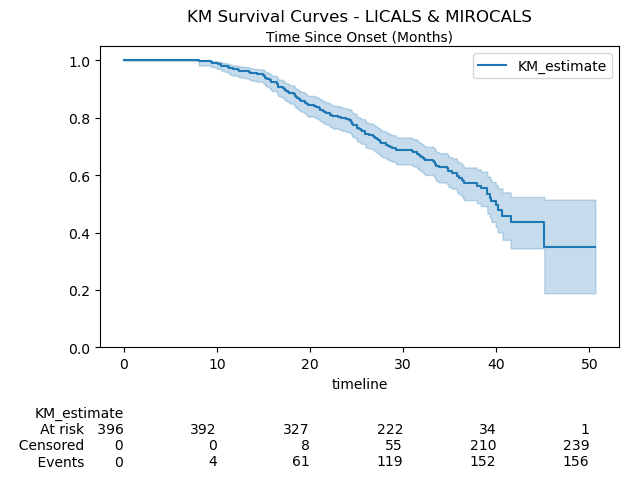

In [1283]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Disease_Duration'], event_observed = df['Event'])

# kmf.survival_function_.plot()
kmf.plot_survival_function(at_risk_counts = True)
plt.title('KM Survival Curves - LICALS & MIROCALS')
plt.xlabel('Time Since Onset (Months)')
plt.ylabel('Survival Probability')
plt.ylim(0,1.05)
# plt.grid(True)

/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_42474/1973559091.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Clinical Trials Cluster")


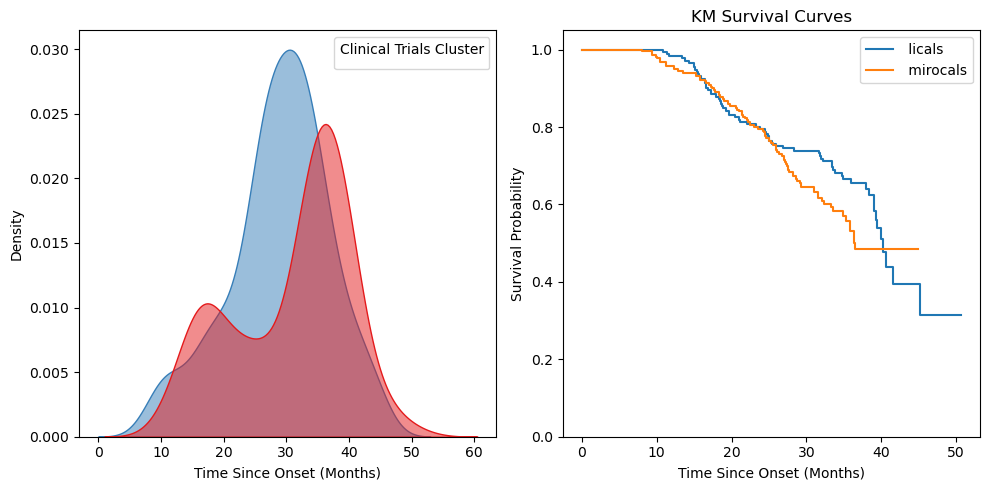

In [1284]:
# create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Plot 1: KDE plot ---
sns.kdeplot(data=df, x='Disease_Duration', hue='Expt', fill=True, alpha=0.5, palette='Set1', ax=axes[0])
# axes[0].set_title("Clinical Trials Grouping of Survival Times")
axes[0].set_xlabel("Time Since Onset (Months)")
axes[0].set_ylabel("Density")
axes[0].legend(title="Clinical Trials Cluster")


# --- Plot 2: Kaplan-Meier curves ---
kmf = KaplanMeierFitter()
for group in sorted(df['Expt'].unique()):
    mask = df['Expt'] == group
    subset = df.loc[mask, ['Disease_Duration', 'Event']].dropna()
    if subset.empty:
        print(f"Skipping empty group {group}")
        continue
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=f' {group}')
    kmf.plot(ax=axes[1], ci_show=False)  # plot on second subplot

axes[1].set_title("KM Survival Curves")
axes[1].set_xlabel("Time Since Onset (Months)")
axes[1].set_ylabel("Survival Probability")
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_42474/170623229.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Clinical Trials Cluster")


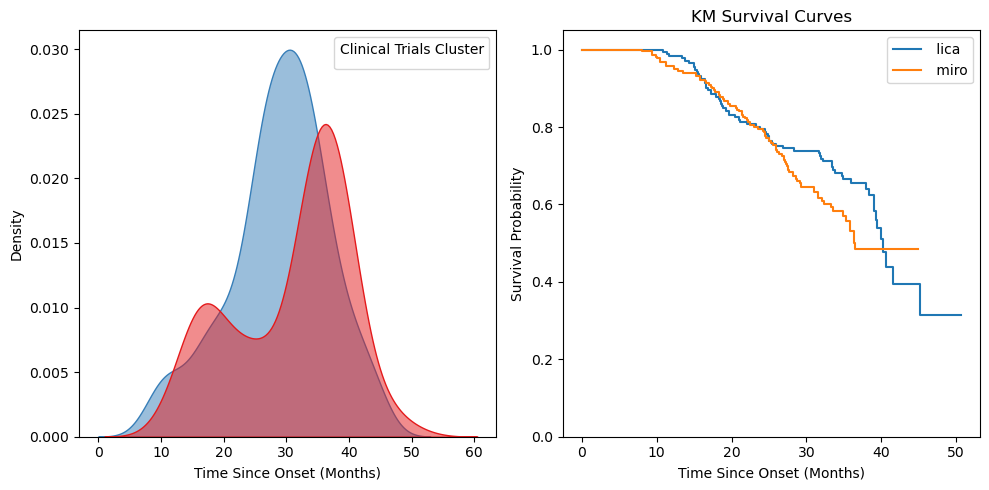

In [1285]:
# create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Plot 1: KDE plot ---
sns.kdeplot(data=df, x='Disease_Duration', hue='Study_id', fill=True, alpha=0.5, palette='Set1', ax=axes[0])
# axes[0].set_title("Clinical Trials Grouping of Survival Times")
axes[0].set_xlabel("Time Since Onset (Months)")
axes[0].set_ylabel("Density")
axes[0].legend(title="Clinical Trials Cluster")


# --- Plot 2: Kaplan-Meier curves ---
kmf = KaplanMeierFitter()
for group in sorted(df['Study_id'].unique()):
    mask = df['Study_id'] == group
    subset = df.loc[mask, ['Disease_Duration', 'Event']].dropna()
    if subset.empty:
        print(f"Skipping empty group {group}")
        continue
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=f' {group}')
    kmf.plot(ax=axes[1], ci_show=False)  # plot on second subplot

axes[1].set_title("KM Survival Curves")
axes[1].set_xlabel("Time Since Onset (Months)")
axes[1].set_ylabel("Survival Probability")
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_42474/3831278038.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Clinical Trials Cluster")


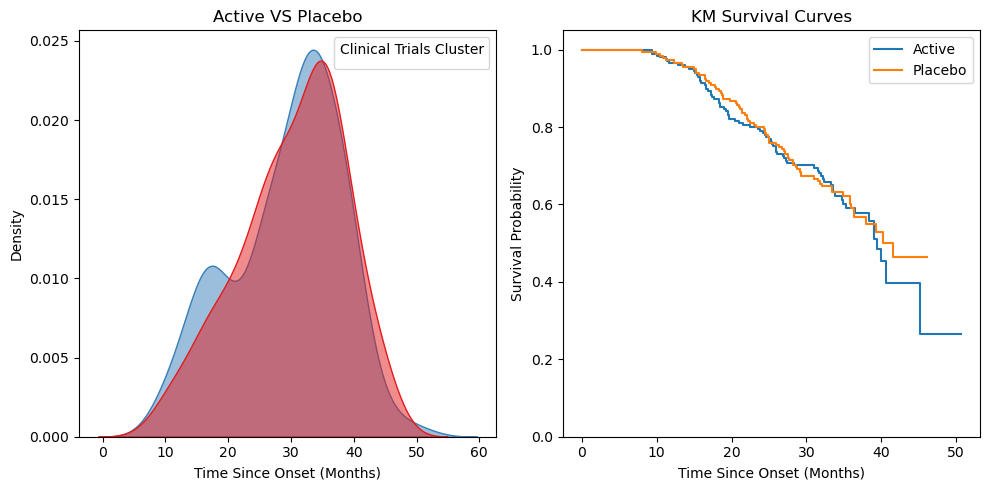

In [1286]:
# create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Plot 1: KDE plot ---
sns.kdeplot(data=df, x='Disease_Duration', hue='Study_Arm', fill=True, alpha=0.5, palette='Set1', ax=axes[0])
# axes[0].set_title("Clinical Trials Grouping of Survival Times")
axes[0].set_title("Active VS Placebo")
axes[0].set_xlabel("Time Since Onset (Months)")
axes[0].set_ylabel("Density")
axes[0].legend(title="Clinical Trials Cluster")


# --- Plot 2: Kaplan-Meier curves ---
kmf = KaplanMeierFitter()
for group in sorted(df['Study_Arm'].unique()):
    mask = df['Study_Arm'] == group
    subset = df.loc[mask, ['Disease_Duration', 'Event']].dropna()
    if subset.empty:
        print(f"Skipping empty group {group}")
        continue
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=f'{group}')
    kmf.plot(ax=axes[1], ci_show=False)  # plot on second subplot

axes[1].set_title("KM Survival Curves")
axes[1].set_xlabel("Time Since Onset (Months)")
axes[1].set_ylabel("Survival Probability")
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

#### **Cox PH**

In [1287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 396 non-null    object 
 1   Event                      396 non-null    int64  
 2   Study_Arm                  396 non-null    object 
 3   Disease_Duration           396 non-null    float64
 4   Expt                       396 non-null    object 
 5   Study_id                   396 non-null    object 
 6   Age                        396 non-null    float64
 7   TRICALS                    396 non-null    float64
 8   Diagnostic_Delay           396 non-null    float64
 9   Vital_capacity             396 non-null    float64
 10  Onset (Limb)               396 non-null    int64  
 11  European (Yes)             396 non-null    int64  
 12  Sex (Male)                 396 non-null    int64  
 13  Sex (Male) : onset (Limb)  396 non-null    int64  
 14 

In [1288]:
# Identify categorical columns
cat_cols1 = ['Expt', 'Study_Arm', 'Study_id']  # replace with your actual categorical columns

# One-hot encode
df_onehot1 = pd.get_dummies(df, columns=cat_cols1, drop_first=True)
print(df_onehot1.columns)

df_onehot1['Study_Arm_Placebo'] = df_onehot1['Study_Arm_Placebo'].astype(int)
df_onehot1['Expt_mirocals'] = df_onehot1['Expt_mirocals'].astype(int)
df_onehot1['Study_id_miro'] = df_onehot1['Study_id_miro'].astype(int)

# df_onehot1['Expt_riluzole'] = df_onehot1['Expt_riluzole'].astype(int)
# df_onehot1['Study_id_301'] = df_onehot1['Study_id_301'].astype(int)
# df_onehot1['Study_id_302'] = df_onehot1['Study_id_302'].astype(int)
# df_onehot1['Study_id_lica'] = df_onehot1['Study_id_lica'].astype(int)


Index(['subject_id', 'Event', 'Disease_Duration', 'Age', 'TRICALS',
       'Diagnostic_Delay', 'Vital_capacity', 'Onset (Limb)', 'European (Yes)',
       'Sex (Male)', 'Sex (Male) : onset (Limb)', 'Sex (Male) : Age',
       'Age : onset (Limb)', 'Age : TRICALS', 'Expt_mirocals',
       'Study_Arm_Placebo', 'Study_id_miro'],
      dtype='object')


In [1289]:
df_onehot1.head(2)

,subject_id,Event,Disease_Duration,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Sex (Male) : Age,Age : onset (Limb),Age : TRICALS,Expt_mirocals,Study_Arm_Placebo,Study_id_miro
0,P01001,0,32.600526,-0.355001,-0.075830,2.681058,4.672829,1,1,1,1,54.762491,54.762491,-269.505759,0,1,0
1,P01002,1,41.538765,0.255274,-1.168542,3.051071,4.595120,1,1,0,0,0.000000,61.160849,-388.189012,0,1,0


In [1290]:
# Train / Test split
print(df_onehot1.shape)

# Separate features from survival info
X = df_onehot1.drop(columns=['Disease_Duration', 'Event'])
y_duration = df_onehot1['Disease_Duration']
y_event = df_onehot1['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.2, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

# print(train_df)
# print(test_df)


(396, 17)


In [1291]:
print(train_df.shape, test_df.shape)

(316, 17) (80, 17)


In [1292]:
from lifelines.utils import concordance_index


def backward_elimination_survival(train_df, test_df, duration_col, event_col, threshold=0.05, verbose=True):
    """
    Perform backward elimination for survival analysis using CoxPH model.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training dataset including features, duration_col, and event_col.
    test_df : pd.DataFrame
        Test dataset including features, duration_col, and event_col.
    duration_col : str
        Name of the duration column.
    event_col : str
        Name of the event indicator column (1=event, 0=censored).
    threshold : float
        p-value threshold for variable removal.
    verbose : bool
        Whether to print progress.

    Returns
    -------
    dict with keys:
        - "final_model": fitted CoxPHFitter object
        - "aic": final model AIC
        - "cindex_train": concordance index on training set
        - "cindex_test": concordance index on test set
        - "selected_variables": list of chosen predictors
    """

    predictors = [col for col in train_df.columns if col not in [duration_col, event_col]]
    
    while True:
        cph = CoxPHFitter()
        cph.fit(train_df[[duration_col, event_col] + predictors], duration_col, event_col)
        
        # Evaluate
        aic = cph.AIC_partial_
        cindex_train = concordance_index(
            train_df[duration_col], -cph.predict_partial_hazard(train_df), train_df[event_col]
        )
        cindex_test = concordance_index(
            test_df[duration_col], -cph.predict_partial_hazard(test_df), test_df[event_col]
        )

        if verbose:
            print("\nModel with variables:", predictors)
            print(f"AIC = {aic:.3f}, Train C-index = {cindex_train:.3f}, Test C-index = {cindex_test:.3f}")

        # Check highest p-value
        summary = cph.summary.sort_values("p")
        worst_pval = summary["p"].max()
        worst_feature = summary["p"].idxmax()

        if worst_pval > threshold:
            if verbose:
                print(f"Removing {worst_feature} (p = {worst_pval:.3f})")
            predictors.remove(worst_feature)
        else:
            break  # stop when all features are significant

    return {
        "final_model": cph,
        "aic": aic,
        "cindex_train": cindex_train,
        "cindex_test": cindex_test,
        "selected_variables": predictors,
    }


In [1293]:
df_onehot1.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Age', 'TRICALS',
       'Diagnostic_Delay', 'Vital_capacity', 'Onset (Limb)', 'European (Yes)',
       'Sex (Male)', 'Sex (Male) : onset (Limb)', 'Sex (Male) : Age',
       'Age : onset (Limb)', 'Age : TRICALS', 'Expt_mirocals',
       'Study_Arm_Placebo', 'Study_id_miro'],
      dtype='object')

In [1294]:
corr_matrix = df_onehot1.drop(columns=['Disease_Duration', 'Event', 'subject_id']).corr().abs()

high_corr_pairs = []

cols = corr_matrix.columns

for idx_i in range(len(cols)):
    for idx_j in range(idx_i + 1, len(cols)):
        col_i = cols[idx_i]
        col_j = cols[idx_j]
        corr_val = corr_matrix.iloc[idx_i, idx_j]
        if corr_val > 0.95:
            high_corr_pairs.append((col_i, col_j, corr_val))

for a, b, c in high_corr_pairs:
    print(f"{a} — {b}: {c:.3f}")


Sex (Male) — Sex (Male) : Age: 0.952
Expt_mirocals — Study_id_miro: 1.000


In [1295]:
train_dff = train_df.drop(columns=['subject_id', 'Study_id_miro', 'Sex (Male) : Age'
                                   # 'Expt_mirocals',
       # 'Expt_riluzole', 'Study_Arm_Placebo', 'Study_id_301', 'Study_id_302', 'Study_id_lica', 
       ])

test_dff = test_df.drop(columns=['subject_id', 'Study_id_miro', 'Sex (Male) : Age'
                                   # 'Expt_mirocals',
       # 'Expt_riluzole', 'Study_Arm_Placebo', 'Study_id_301', 'Study_id_302', 'Study_id_lica', 
       ])

backward_elimination_survival(train_df = train_dff, test_df = test_dff, 
                              duration_col = 'Disease_Duration', event_col = 'Event', 
                              threshold=0.05, verbose=False)


{'final_model': <lifelines.CoxPHFitter: fitted with 316 total observations, 191 right-censored observations>,
 'aic': np.float64(997.9039038507215),
 'cindex_train': np.float64(0.8970902394106814),
 'cindex_test': np.float64(0.9002242152466368),
 'selected_variables': ['Age', 'TRICALS', 'Expt_mirocals']}

In [1296]:
train_dff.columns

Index(['Age', 'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset (Limb)',
       'European (Yes)', 'Sex (Male)', 'Sex (Male) : onset (Limb)',
       'Age : onset (Limb)', 'Age : TRICALS', 'Expt_mirocals',
       'Study_Arm_Placebo', 'Disease_Duration', 'Event'],
      dtype='object')

In [1297]:
cph = CoxPHFitter()

covars = [
  'Age', 'TRICALS', 'Expt_mirocals'
  ]

cph.fit(train_dff[["Disease_Duration", "Event"] + covars], duration_col="Disease_Duration", event_col="Event")
cph.print_summary()
result = cph.summary.round(2)
# result.to_csv('/Users/Apple/Downloads/01_DigitalTwin_2/Results_06_10_2025/ALS_Baseline_CoxPH_results.csv')

<lifelines.CoxPHFitter: fitted with 316 total observations, 191 right-censored observations>
             duration col = 'Disease_Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 316
number of events observed = 125
   partial log-likelihood = -495.95
         time fit was run = 2025-11-19 23:52:05 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age           -0.44      0.65      0.12           -0.67           -0.20                0.51                0.82
TRICALS        2.99     19.90      0.21            2.58            3.40               13.18               30.04
Expt_mirocals -0.40      0.67      0.20           -0.79           -0.02                0.45                0.98

               cmp to     z      p  -log2(p)
covariate                                   
Age              0.00 -3.62 <0.005     11.74
TRICALS          0.00 14.24 <0.005    150.42
Expt_mirocals    0.00 -2.04   0.04      4.60
---
Concordance = 0.90
Partial AIC = 997.90
log-likelihood ratio test = 317.82 on 3 df
-log2(p) of ll-ratio test = 225.42

Text(0.5, 1.0, 'LICALS & MIROCALS')

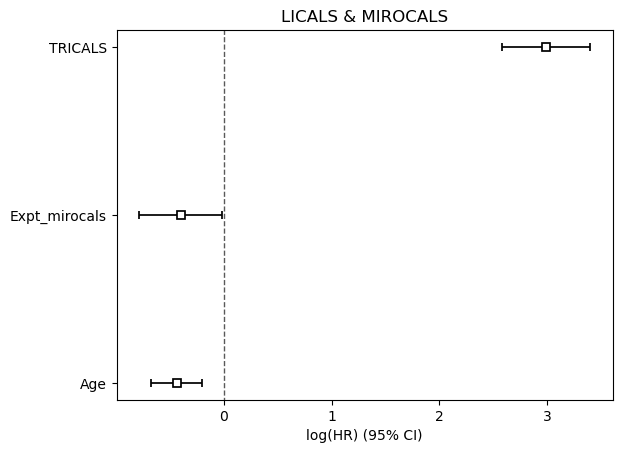

In [1298]:
cph.plot()
plt.title("LICALS & MIROCALS")

In [1299]:
# Check model performance on test set
from lifelines.utils import concordance_index

# Predict partial hazards (risk scores) on test set
test_pred = cph.predict_partial_hazard(test_dff)

# Concordance Index
c_index = concordance_index(
    event_times=test_dff["Disease_Duration"],
    predicted_scores=-test_pred,   # negative, because higher hazard = higher risk
    event_observed=test_dff["Event"]
)

print("C-index on test set:", c_index)

C-index on test set: 0.9002242152466368


<lifelines.CoxPHFitter: fitted with 316 total observations, 191 right-censored observations>
             duration col = 'Disease_Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 316
number of events observed = 125
   partial log-likelihood = -495.60
         time fit was run = 2025-11-19 23:52:06 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Age              -0.49      0.61      0.13           -0.74           -0.24                0.48                0.79
Diagnostic_Delay  0.38      1.46      0.23           -0.07            0.82                0.93                2.27
Onset (Limb)      0.38      1.46      0.23           -0.08            0.83                0.93                2.30
Sex (Male)       -0.06      0.94      0.19           -0.44            0.31                0.64                1.37
TRICALS           3.10     22.20      0.23            2.65            3.55               14.14               34.86

                  cmp to     z      p  -log2(p)
covariate                                      
Age                 0.00 -3.79 <0.005     12.70
Diagnostic_Delay    0.00  1.65   0.10      3.34
Onset (Limb)        0.00  1.63   0.10      3.26
Sex (Male)          0.00 -0.33   0.74      0.43
TRICALS             0.00 13.47 <0.005    134.94
---
Concordance = 0.90
Partial AIC = 1001.21
log-likelihood ratio test = 318.52 on 5 df
-log2(p) of ll-ratio test = 219.19

Text(0.5, 1.0, 'LICALS & MIROCALS')

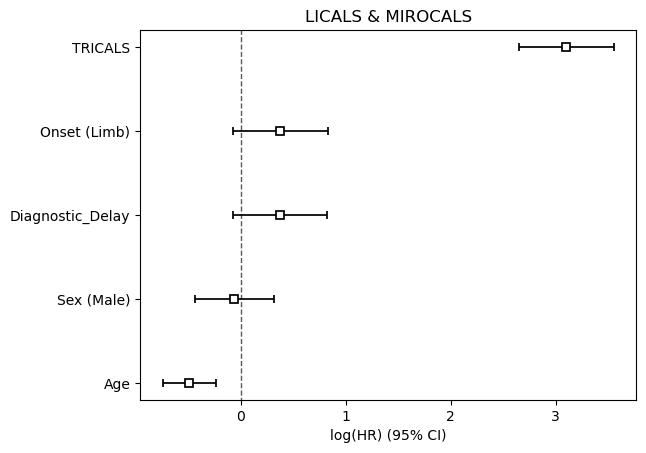

In [1300]:
cph = CoxPHFitter()

covars = [
  'Age', 'Diagnostic_Delay', 'Onset (Limb)', 'Sex (Male)',
  'TRICALS'#, 'Expt_mirocals' #, 'European (Yes)'
  ]

cph.fit(train_dff[["Disease_Duration", "Event"] + covars], duration_col="Disease_Duration", event_col="Event")
cph.print_summary()
result = cph.summary.round(2)
# result.to_csv('/Users/Apple/Downloads/01_DigitalTwin_2/Results_06_10_2025/ALS_Baseline_CoxPH_results.csv')


cph.plot()
plt.title("LICALS & MIROCALS")

In [1301]:
# Check model performance on test set
from lifelines.utils import concordance_index

# Predict partial hazards (risk scores) on test set
test_pred = cph.predict_partial_hazard(test_dff)

# Concordance Index
c_index = concordance_index(
    event_times=test_dff["Disease_Duration"],
    predicted_scores=-test_pred,   # negative, because higher hazard = higher risk
    event_observed=test_dff["Event"]
)

print("C-index on test set:", c_index)


C-index on test set: 0.8934977578475336


In [1302]:
# train_df = train_df.drop(columns='Study_Arm')

In [1303]:
train_df.columns

Index(['subject_id', 'Age', 'TRICALS', 'Diagnostic_Delay', 'Vital_capacity',
       'Onset (Limb)', 'European (Yes)', 'Sex (Male)',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS', 'Expt_mirocals', 'Study_Arm_Placebo', 'Study_id_miro',
       'Disease_Duration', 'Event'],
      dtype='object')

## ***Compute prognostic score (centered at mean)***

<lifelines.CoxPHFitter: fitted with 316 total observations, 191 right-censored observations>
             duration col = 'Disease_Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 316
number of events observed = 125
   partial log-likelihood = -495.60
         time fit was run = 2025-11-19 23:52:06 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Age              -0.49      0.61      0.13           -0.74           -0.24                0.48                0.79
Diagnostic_Delay  0.38      1.46      0.23           -0.07            0.82                0.93                2.27
Onset (Limb)      0.38      1.46      0.23           -0.08            0.83                0.93                2.30
Sex (Male)       -0.06      0.94      0.19           -0.44            0.31                0.64                1.37
TRICALS           3.10     22.20      0.23            2.65            3.55               14.14               34.86

                  cmp to     z      p  -log2(p)
covariate                                      
Age                 0.00 -3.79 <0.005     12.70
Diagnostic_Delay    0.00  1.65   0.10      3.34
Onset (Limb)        0.00  1.63   0.10      3.26
Sex (Male)          0.00 -0.33   0.74      0.43
TRICALS             0.00 13.47 <0.005    134.94
---
Concordance = 0.90
Partial AIC = 1001.21
log-likelihood ratio test = 318.52 on 5 df
-log2(p) of ll-ratio test = 219.19

Text(0.5, 1.0, 'LICALS & MIROCALS')

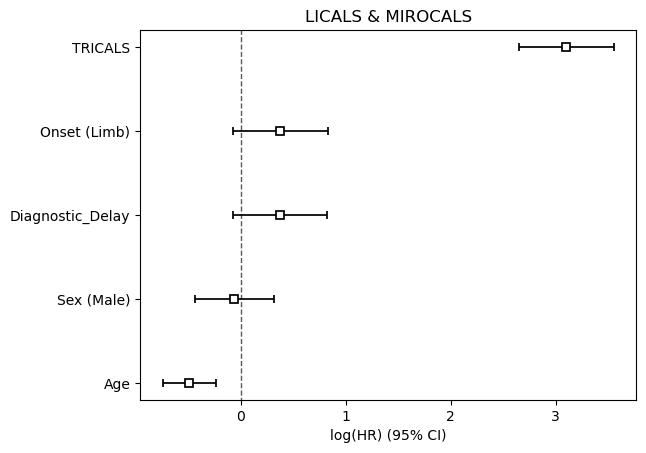

In [1304]:
train_dff = train_df.drop(columns=['subject_id', 'Study_id_miro', 'Sex (Male) : Age'
                                   # 'Expt_mirocals',
       # 'Expt_riluzole', 'Study_Arm_Placebo', 'Study_id_301', 'Study_id_302', 'Study_id_lica', 
       ])

test_dff = test_df.drop(columns=['subject_id', 'Study_id_miro', 'Sex (Male) : Age'
                                   # 'Expt_mirocals',
       # 'Expt_riluzole', 'Study_Arm_Placebo', 'Study_id_301', 'Study_id_302', 'Study_id_lica', 
       ])

backward_elimination_survival(train_df = train_dff, test_df = test_dff, 
                              duration_col = 'Disease_Duration', event_col = 'Event', 
                              threshold=0.05, verbose=False)

cph = CoxPHFitter()

covars = [
  'Age', 'Diagnostic_Delay', 'Onset (Limb)', 'Sex (Male)',
  'TRICALS'#, 'Expt_mirocals' #, 'European (Yes)'
  ]

cph.fit(train_dff[["Disease_Duration", "Event"] + covars], duration_col="Disease_Duration", event_col="Event")
cph.print_summary()
result = cph.summary.round(2)
# result.to_csv('/Users/Apple/Downloads/01_DigitalTwin_2/Results_06_10_2025/ALS_Baseline_CoxPH_results.csv')


cph.plot()
plt.title("LICALS & MIROCALS")

#### ***Training set***

In [1305]:
betas = cph.params_
betas

covariate
Age                -0.489796
Diagnostic_Delay    0.375716
Onset (Limb)        0.376924
Sex (Male)         -0.062611
TRICALS             3.100281
Name: coef, dtype: float64

In [1306]:
betas = cph.params_

cov_centered = train_dff[betas.index] - train_dff[betas.index].mean()

train_dff['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
train_dff['relative_hazard'] = np.exp(train_dff['prognostic_score'])

# Categorize prognostic score
train_dff['risk'] = np.where(train_dff['prognostic_score'] < train_dff['prognostic_score'].median(), 1, 0)

In [1307]:
betas

covariate
Age                -0.489796
Diagnostic_Delay    0.375716
Onset (Limb)        0.376924
Sex (Male)         -0.062611
TRICALS             3.100281
Name: coef, dtype: float64

##### ***Compare the KM curves for 'risk' groups***

In [1308]:
train_dff.head(2)

,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Age : TRICALS,Expt_mirocals,Study_Arm_Placebo,Disease_Duration,Event,prognostic_score,relative_hazard,risk
239,0.281614,2.027815,1.919859,4.382027,1,1,1,1,61.437,-133.732000,1,0,10.080894,1,5.866957,353.172703,0
337,-1.532990,-1.593412,2.241985,4.430817,1,1,1,1,42.412,-292.699854,1,0,31.308967,0,-4.350050,0.012906,1


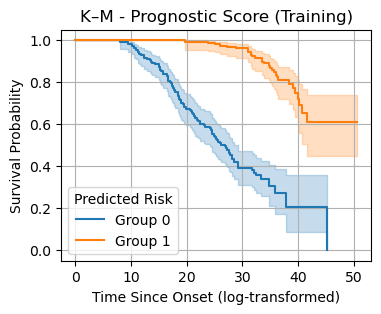

In [1309]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(4,3))

for group in train_dff['risk'].unique():
    mask = train_dff['risk'] == group
    kmf.fit(train_dff['Disease_Duration'][mask], event_observed=train_dff['Event'][mask],
            label=f'Group {group}')
    kmf.plot_survival_function(ci_show=True)

plt.title("K–M - Prognostic Score (Training)")
plt.xlabel("Time Since Onset (log-transformed)")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted Risk")
plt.grid(True)
plt.show()

## Try using the sigmoid fucntion to determine risk. Just make sure is possible ask online

##### ***Statistical comparison between groups Use the log-rank test from lifelines***

In [1310]:
from lifelines.statistics import logrank_test

group0 = train_dff[train_dff["risk"] == 0]
group1 = train_dff[train_dff["risk"] == 1]

results = logrank_test(group0["Disease_Duration"], group1["Disease_Duration"],
                       event_observed_A=group0["Event"],
                       event_observed_B=group1["Event"])

print(results.summary)


   test_statistic             p   -log2(p)
0      119.437432  8.400363e-28  89.943535


#### ***Test Set***

In [1311]:
# Test set
betas = cph.params_

cov_centered = test_dff[betas.index] - test_dff[betas.index].mean()

test_dff['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
test_dff['relative_hazard'] = np.exp(test_dff['prognostic_score'])

# Categorize prognostic score
test_dff['risk'] = np.where(test_dff['prognostic_score'] < test_dff['prognostic_score'].median(), 1, 0)
test_dff.head(2)

,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Age : TRICALS,Expt_mirocals,Study_Arm_Placebo,Disease_Duration,Event,prognostic_score,relative_hazard,risk
219,0.369649,-0.901295,2.676628,4.890349,1,1,0,0,62.360000,-374.056546,1,1,35.016967,0,-2.334706,0.096839,1
70,-2.759280,-1.678250,2.752681,4.204693,1,1,1,1,29.555099,-207.241328,0,0,33.684625,0,-3.244983,0.038969,1


##### ***Compare the KM curves for 'risk' groups***

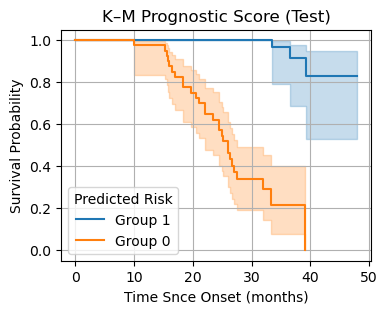

In [1312]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(4,3))

for group in test_dff['risk'].unique():
    mask = test_dff['risk'] == group
    kmf.fit(test_dff['Disease_Duration'][mask], event_observed=test_dff['Event'][mask],
            label=f'Group {group}')
    kmf.plot_survival_function(ci_show=True)

plt.title("K–M Prognostic Score (Test)")
plt.xlabel("Time Snce Onset (months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted Risk")
plt.grid(True)
plt.show()

##### ***Statistical comparison between groups Use the log-rank test from lifelines***

In [1313]:
from lifelines.statistics import logrank_test

group0 = test_dff[test_dff["risk"] == 0]
group1 = test_dff[test_dff["risk"] == 1]

results = logrank_test(group0["Disease_Duration"], group1["Disease_Duration"],
                       event_observed_A=group0["Event"],
                       event_observed_B=group1["Event"])

print(results.summary)


   test_statistic             p   -log2(p)
0       48.650997  3.058128e-12  38.250488


## ***Estimate Survival Time***

##### ***For training data***

In [1314]:
surv_func = cph.predict_survival_function(train_dff[betas.index])
# print(surv_func)

# plt.figure(figsize=(3,2))
# surv_func.plot()
# plt.title("Predicted Survival Curve for New Patient")
# plt.xlabel("Time")
# plt.ylabel("Survival Probability")
# plt.show()

median_survival_time = []
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
        # fall back: take the maximum available time in the grid
        median_time = surv_curve.median()
        # median_time = surv_curve.index.max()
    median_survival_time.append(median_time)

train_dff['median_survival_time'] = median_survival_time
train_dff.head(2)

,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Age : TRICALS,Expt_mirocals,Study_Arm_Placebo,Disease_Duration,Event,prognostic_score,relative_hazard,risk,median_survival_time
239,0.281614,2.027815,1.919859,4.382027,1,1,1,1,61.437,-133.732000,1,0,10.080894,1,5.866957,353.172703,0,11.686597
337,-1.532990,-1.593412,2.241985,4.430817,1,1,1,1,42.412,-292.699854,1,0,31.308967,0,-4.350050,0.012906,1,0.997702


In [1315]:

surv_func = cph.predict_survival_function(train_dff[betas.index]) #survival function for each patient

median_survival_time = [] # list to store median survival times
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    # else:
    #     # fall back: take the maximum available time in the grid
        # median_time = surv_curve.median()
        # median_time = surv_curve.min()
        # median_time = surv_curve.index.max()
    median_survival_time.append(median_time)

train_dff['median_survival_time'] = median_survival_time
train_dff.head(2)

,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Age : TRICALS,Expt_mirocals,Study_Arm_Placebo,Disease_Duration,Event,prognostic_score,relative_hazard,risk,median_survival_time
239,0.281614,2.027815,1.919859,4.382027,1,1,1,1,61.437,-133.732000,1,0,10.080894,1,5.866957,353.172703,0,11.686597
337,-1.532990,-1.593412,2.241985,4.430817,1,1,1,1,42.412,-292.699854,1,0,31.308967,0,-4.350050,0.012906,1,11.686597


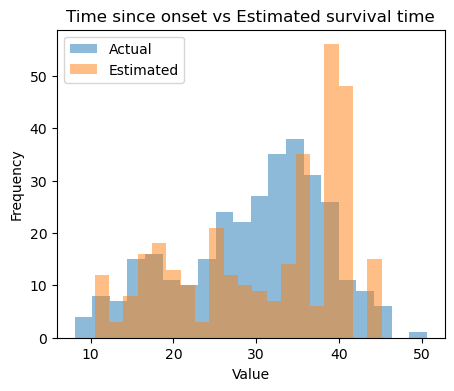

In [1316]:
# Compare distributions
plt.figure(figsize=(5,4))
plt.hist(train_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(train_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Time since onset vs Estimated survival time")
plt.legend()
plt.show()

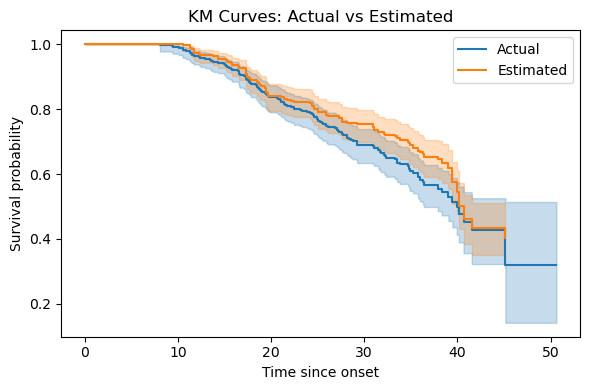

In [1317]:
fig, ax = plt.subplots(figsize=(6,4))

km = KaplanMeierFitter()

# Actual survival
km.fit(train_dff['Disease_Duration'], event_observed=train_dff['Event'], label='Actual')
km.plot_survival_function(ax=ax)

# Estimated survival
km.fit(train_dff['median_survival_time'], event_observed=train_dff['Event'], label='Estimated')
km.plot_survival_function(ax=ax)

ax.set_title("KM Curves: Actual vs Estimated")
ax.set_xlabel("Time since onset")
ax.set_ylabel("Survival probability")
ax.legend()

plt.tight_layout()
plt.show()


##### ***For test data***

In [1318]:
surv_func = cph.predict_survival_function(test_dff[betas.index])
# print(surv_func)

# plt.figure(figsize=(3,2))
# surv_func.plot()
# plt.title("Predicted Survival Curve for New Patient")
# plt.xlabel("Time")
# plt.ylabel("Survival Probability")
# plt.show()

median_survival_time = []
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
        # fall back: take the maximum available time in the grid
        median_time = surv_curve.median()
        # median_time = surv_curve.index.max()
    median_survival_time.append(median_time)

test_dff['median_survival_time'] = median_survival_time
test_dff.head(3)

,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Age : TRICALS,Expt_mirocals,Study_Arm_Placebo,Disease_Duration,Event,prognostic_score,relative_hazard,risk,median_survival_time
219,0.369649,-0.901295,2.676628,4.890349,1,1,0,0,62.360000,-374.056546,1,1,35.016967,0,-2.334706,0.096839,1,0.990340
70,-2.759280,-1.678250,2.752681,4.204693,1,1,1,1,29.555099,-207.241328,0,0,33.684625,0,-3.244983,0.038969,1,0.996101
6,-0.382942,-0.631737,3.013058,4.644391,1,1,0,0,54.469541,-307.570378,0,0,38.349540,0,-1.003982,0.366417,1,45.152431


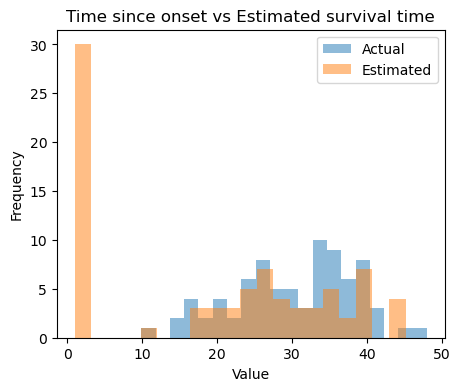

In [1319]:
# Compare distributions
plt.figure(figsize=(5,4))
plt.hist(test_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(test_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated')
# plt.hist(np.log1p(test_dff['median_survival_time']), bins=20, alpha=0.5, label='Estimated2')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Time since onset vs Estimated survival time")
plt.legend()
plt.show()

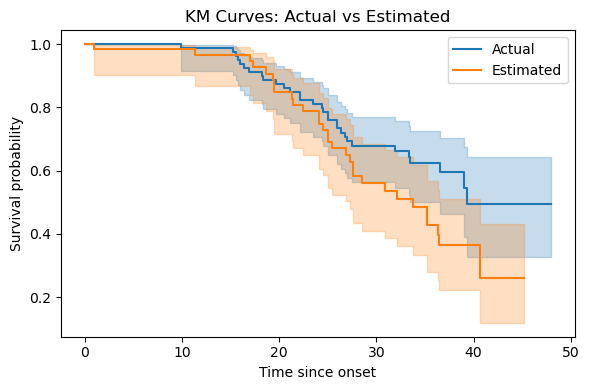

In [1320]:
fig, ax = plt.subplots(figsize=(6,4))

km = KaplanMeierFitter()

# Actual survival
km.fit(test_dff['Disease_Duration'], event_observed=test_dff['Event'], label='Actual')
km.plot_survival_function(ax=ax)

# Estimated survival
km.fit(test_dff['median_survival_time'], event_observed=test_dff['Event'], label='Estimated')
km.plot_survival_function(ax=ax)

ax.set_title("KM Curves: Actual vs Estimated")
ax.set_xlabel("Time since onset")
ax.set_ylabel("Survival probability")
ax.legend()

plt.tight_layout()
plt.show()


## ***Simulate Virtual Placebo***

In [1321]:
df.columns

Index(['subject_id', 'Event', 'Study_Arm', 'Disease_Duration', 'Expt',
       'Study_id', 'Age', 'TRICALS', 'Diagnostic_Delay', 'Vital_capacity',
       'Onset (Limb)', 'European (Yes)', 'Sex (Male)',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

In [1322]:
print(f"{df.Event.value_counts() / df.Event.value_counts().sum()}\n")
print(f"{df['Onset (Limb)'].value_counts() / df['Onset (Limb)'].value_counts().sum()}\n")
print(f'{df['Sex (Male)'].value_counts() / df['Sex (Male)'].value_counts().sum()}\n')
print(f'{df['European (Yes)'].value_counts() / df['European (Yes)'].value_counts().sum()}\n')
# print(df.Riluzole_use.value_counts() / df.Riluzole_use.value_counts().sum())

print(f'Age: {df['Age'].mean():.2f}, {df['Age'].std():.2f}\n')
print(f'TRICALS: {df['TRICALS'].mean():.2f}, {df['TRICALS'].std():.2f}\n')
# print(f'ALSFRS_Rasch: {df['ALSFRS_Rasch'].mean():.2f}, {df['ALSFRS_Rasch'].std():.2f}')
print(f'Diagnostic_Delay: {df['Diagnostic_Delay'].mean():.2f}, {df['Diagnostic_Delay'].std():.2f}')

Event
0    0.606061
1    0.393939
Name: count, dtype: float64

Onset (Limb)
1    0.805556
0    0.194444
Name: count, dtype: float64

Sex (Male)
1    0.661616
0    0.338384
Name: count, dtype: float64

European (Yes)
1    0.989899
0    0.010101
Name: count, dtype: float64

Age: -0.00, 1.00

TRICALS: -0.00, 1.00

Diagnostic_Delay: 2.50, 0.50


In [1323]:
betas

covariate
Age                -0.489796
Diagnostic_Delay    0.375716
Onset (Limb)        0.376924
Sex (Male)         -0.062611
TRICALS             3.100281
Name: coef, dtype: float64

In [1324]:
ons = df['Onset (Limb)'].value_counts() / df['Onset (Limb)'].value_counts().sum()
sex = df['Sex (Male)'].value_counts() / df['Sex (Male)'].value_counts().sum()

In [1325]:
# train_dff.shape[0]

In [1326]:
corr = train_dff[['Age', 'TRICALS', 'Diagnostic_Delay',	'Sex (Male)', 'Onset (Limb)']].corr()
corr

,Age,TRICALS,Diagnostic_Delay,Sex (Male),Onset (Limb)
Age,1.000000,0.372228,0.092308,-0.109871,-0.039644
TRICALS,0.372228,1.000000,-0.445967,-0.106294,-0.169764
Diagnostic_Delay,0.092308,-0.445967,1.000000,0.007442,-0.015371
Sex (Male),-0.109871,-0.106294,0.007442,1.000000,0.157792
Onset (Limb),-0.039644,-0.169764,-0.015371,0.157792,1.000000


In [1327]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def gaussian_copula_samples(n, corr):
    """
    Draw correlated U(0,1) samples using a Gaussian copula.
    corr = correlation matrix (p x p).
    Returns: U (n x p) matrix of uniforms.
    """
    L = np.linalg.cholesky(corr)
    Z = np.random.normal(size=(n, corr.shape[0]))
    Z_corr = Z @ L.T
    U = norm.cdf(Z_corr)
    return U


def simulate_cox_dataset(n,baseline='weibull',lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))
    elif baseline == 'weibull':
        # Weibull inverse CDF: T = (-log U)^(1/rho) / (lam*exp(lp))^(1/rho)
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df


In [1328]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':betas['Age']},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':betas['TRICALS']},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':df['Diagnostic_Delay'].mean(),
                                                           'sd':df['Diagnostic_Delay'].std()},
                                                           'coef':betas['Diagnostic_Delay']},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':df['Vital_capacity'].mean(),
    #                                                        'sd':df['Vital_capacity'].std()},
    #                                                        'coef':betas['Vital_capacity']},

    # binary
    {'name':'Sex (Male)','type':'binary','prob':sex[1],'coef':betas['Sex (Male)']},
    {'name':'Onset (Limb)','type':'binary','prob':ons[1],'coef':betas['Onset (Limb)']}
    
    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
    
    # interactions not included yet!
]

corr = train_dff[['Age', 'TRICALS', 'Diagnostic_Delay',	'Sex (Male)', 'Onset (Limb)']].corr()

df_sim = simulate_cox_dataset(n=train_dff.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
                              censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


df_sim.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex (Male),Onset (Limb)
0,8.686026,1,8.686026,0.000957,-0.312423,-0.563837,3.411283,1,1
1,7.020267,1,7.020267,1.487816,-0.793987,-0.089496,2.826801,1,1
2,12.166110,1,12.166110,-1.023700,-0.874897,-0.947517,3.116808,1,1


In [1329]:
sim_onehot = df_sim
sim_onehot.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex (Male),Onset (Limb)
0,8.686026,1,8.686026,0.000957,-0.312423,-0.563837,3.411283,1,1
1,7.020267,1,7.020267,1.487816,-0.793987,-0.089496,2.826801,1,1
2,12.166110,1,12.166110,-1.023700,-0.874897,-0.947517,3.116808,1,1


In [1330]:
# Simulated prognostic score
betas = cph.params_

cov_centered = sim_onehot[betas.index] - sim_onehot[betas.index].mean()

sim_onehot['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
sim_onehot['relative_hazard'] = np.exp(sim_onehot['prognostic_score'])

# Categorize prognostic score
sim_onehot['risk'] = np.where(sim_onehot['prognostic_score'] < sim_onehot['prognostic_score'].mean(), 1, 0)
sim_onehot.head(2)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex (Male),Onset (Limb),prognostic_score,relative_hazard,risk
0,8.686026,1,8.686026,0.000957,-0.312423,-0.563837,3.411283,1,1,-1.126177,0.324271,1
1,7.020267,1,7.020267,1.487816,-0.793987,-0.089496,2.826801,1,1,0.360683,1.434308,0


In [1331]:
sim_onehot.risk.value_counts()

risk
1    169
0    147
Name: count, dtype: int64

In [1332]:
# Survival time for simulated patients
surv_func = cph.predict_survival_function(sim_onehot[betas.index])

median_survival_time = []
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    # else:
    #     # fall back: take the maximum available time in the grid
    #     median_time = surv_curve.median()
    median_survival_time.append(median_time)

sim_onehot['median_survival_time'] = median_survival_time
sim_onehot.head(2)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex (Male),Onset (Limb),prognostic_score,relative_hazard,risk,median_survival_time
0,8.686026,1,8.686026,0.000957,-0.312423,-0.563837,3.411283,1,1,-1.126177,0.324271,1,45.152431
1,7.020267,1,7.020267,1.487816,-0.793987,-0.089496,2.826801,1,1,0.360683,1.434308,0,36.400825


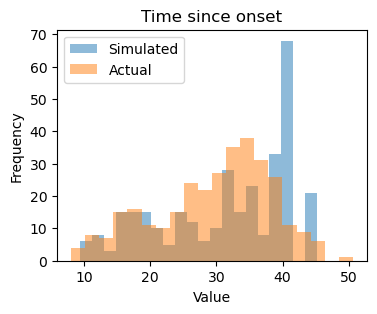

In [1333]:
# Compare distributions
plt.figure(figsize=(4,3))
# plt.hist(train_df['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(sim_onehot['median_survival_time'], bins=20, alpha=0.5, label='Simulated')
plt.hist(train_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Time since onset")
plt.legend()
plt.show()

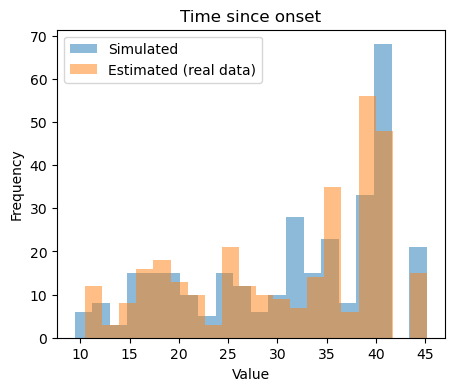

In [1334]:
# Compare distributions
plt.figure(figsize=(5,4))
# plt.hist(train_df['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(sim_onehot['median_survival_time'], bins=20, alpha=0.5, label='Simulated')
plt.hist(train_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated (real data)')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Time since onset")
plt.legend()
plt.show()

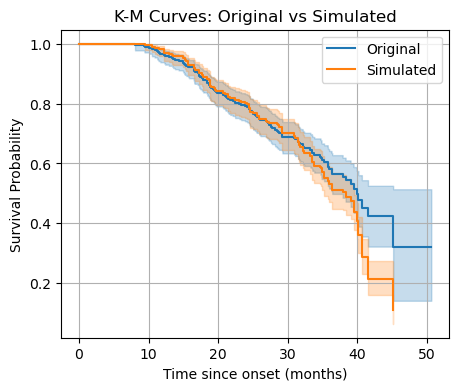

In [1335]:
# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(train_dff['Disease_Duration'], event_observed=train_dff['Event'], label='Original')

# Simulated data
km_sim1 = KaplanMeierFitter()
km_sim1.fit(sim_onehot['median_survival_time'], event_observed=sim_onehot['event'], label='Simulated')

# # Simulated data
# km_sim2 = KaplanMeierFitter()
# km_sim2.fit(df_sim['time'], event_observed=df_sim['event'], label='Simulated event')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim1.plot()
# km_sim2.plot()
plt.title('K-M Curves: Original vs Simulated')
plt.xlabel('Time since onset (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


##### 1. Compare survival distributions

In [1336]:
# sim_onehot.median_survival_time.describe()

In [1337]:
# train_df.Disease_Durationc.describe()

In [1338]:
sim_onehot.risk.value_counts()

risk
1    169
0    147
Name: count, dtype: int64

##### 2. Compare covariate distributions

In [1339]:
sim_onehot.columns

Index(['time', 'event', 'true_survival_time', 'linear_predictor', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Sex (Male)', 'Onset (Limb)',
       'prognostic_score', 'relative_hazard', 'risk', 'median_survival_time'],
      dtype='object')

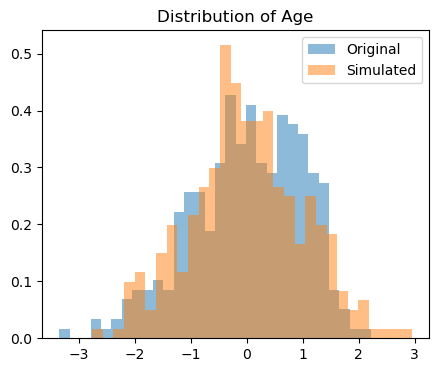

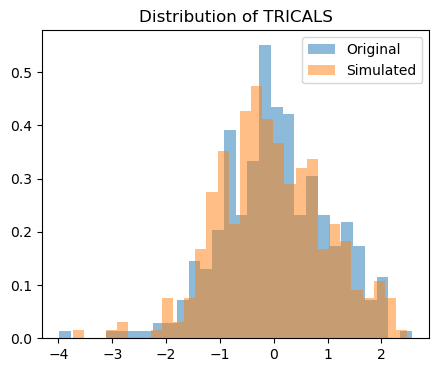

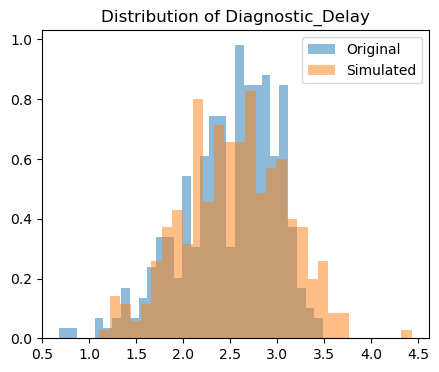

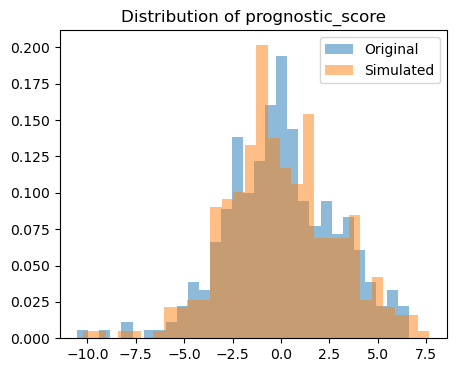

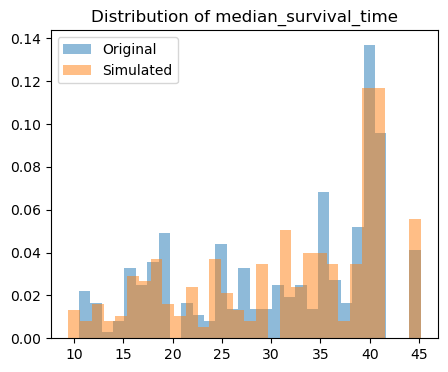

In [1340]:
for col in ['Age', 'TRICALS',  'Diagnostic_Delay', 'prognostic_score', 'median_survival_time']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(train_dff[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_onehot[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()


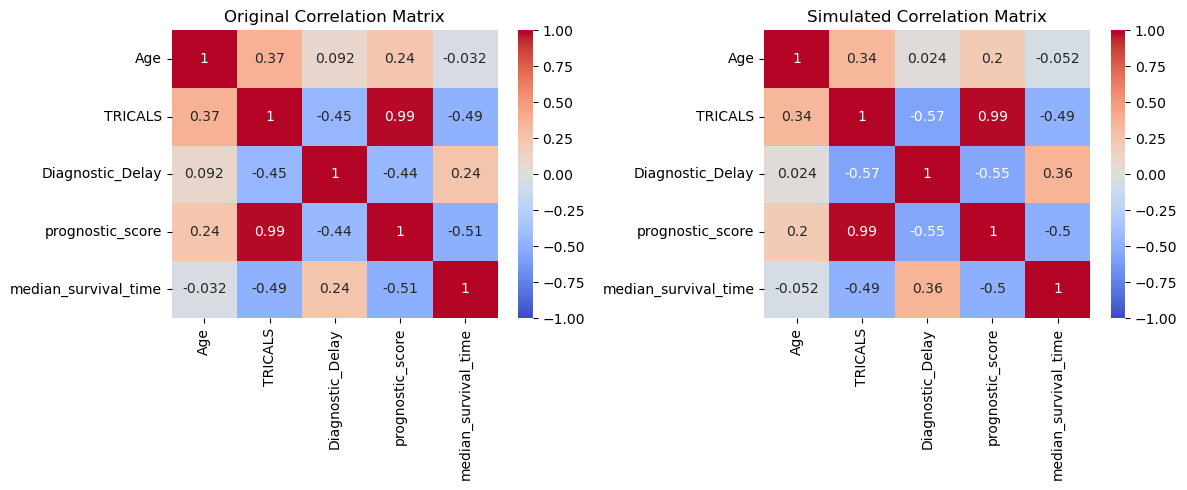

In [1341]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['Age', 'TRICALS', 'Diagnostic_Delay', 'prognostic_score', 'median_survival_time']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(train_dff[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_onehot[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()


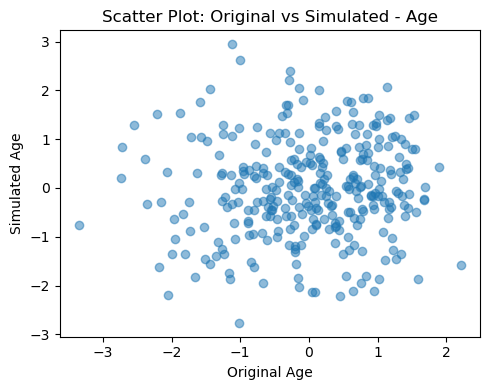

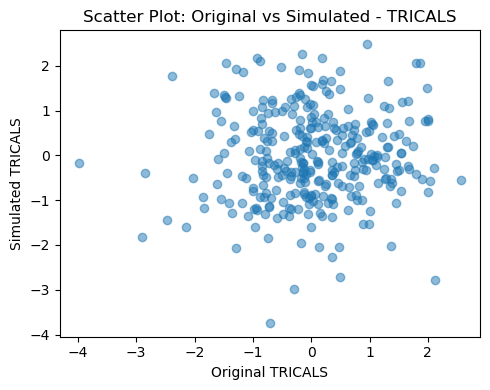

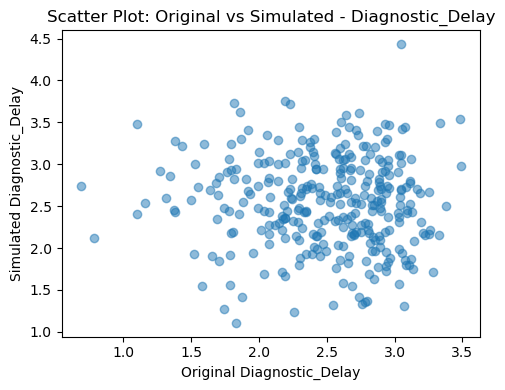

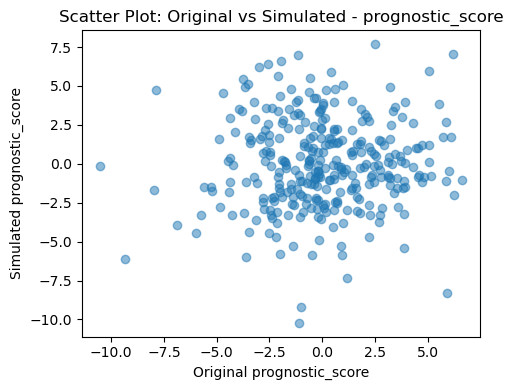

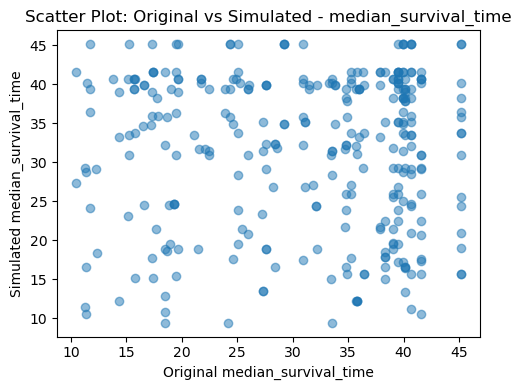

In [1342]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay', 'prognostic_score', 'median_survival_time']:  
    plt.figure(figsize=(5,4))

    plt.scatter(train_dff[col], sim_onehot[col], alpha=0.5)

    plt.xlabel(f'Original {col}')
    plt.ylabel(f'Simulated {col}')
    plt.title(f'Scatter Plot: Original vs Simulated - {col}')

    plt.tight_layout()
    plt.show()


##### 3. Check event proportions

In [1343]:
print("Original events:", train_df['Event'].sum(), " / ", len(train_df))
print("Simulated events:", sim_onehot['event'].sum(), " / ", len(sim_onehot))

Original events: 125  /  316
Simulated events: 206  /  316


##### 4. Compare Cox model coefficients

In [1344]:
sim_onehot.columns

Index(['time', 'event', 'true_survival_time', 'linear_predictor', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Sex (Male)', 'Onset (Limb)',
       'prognostic_score', 'relative_hazard', 'risk', 'median_survival_time'],
      dtype='object')

In [1345]:
betas.to_dict()

{'Age': -0.4897959122747294,
 'Diagnostic_Delay': 0.3757159749382647,
 'Onset (Limb)': 0.37692366982910536,
 'Sex (Male)': -0.06261108636979569,
 'TRICALS': 3.1002811774962478}

In [1346]:
# sim_onehot1 = sim_onehot[['Age','TRICALS', 'ALSFRS_Rasch', 'Diagnosis_delay', 'Sex_Male','Height',
#        'Riluzole_use_Yes', 'European_1', 'Onset_site_limb','Sex_onset_limb', 'Sex_Riluzole',
#        'Trical_Riluzole', 'event', 'median_survival_time']]

In [1347]:
sim_onehot1 = sim_onehot[betas.index.tolist() + ['event', 'median_survival_time']]
sim_onehot1.head(2)

,Age,Diagnostic_Delay,Onset (Limb),Sex (Male),TRICALS,event,median_survival_time
0,-0.312423,3.411283,1,1,-0.563837,1,45.152431
1,-0.793987,2.826801,1,1,-0.089496,1,36.400825


In [1348]:
sim_onehot1 = sim_onehot1.copy()
# sim_onehot1['Sex_onset_limb'] = sim_onehot1['Sex']*sim_onehot1['Onset_site']
# sim_onehot1['Age_onset_limb'] = sim_onehot1['Age']*sim_onehot1['Onset_site']

In [1349]:
sim_onehot1.head(2)

,Age,Diagnostic_Delay,Onset (Limb),Sex (Male),TRICALS,event,median_survival_time
0,-0.312423,3.411283,1,1,-0.563837,1,45.152431
1,-0.793987,2.826801,1,1,-0.089496,1,36.400825


In [1350]:
# Train / Test split

# Separate features from survival info
X = sim_onehot1.drop(columns=['median_survival_time', 'event'])
y_duration = sim_onehot1['median_survival_time']
y_event = sim_onehot1['event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.2, random_state=4
)

# Combine back for lifelines format
simtrain_df = X_train.copy()
simtrain_df['median_survival_time'] = y_duration_train
simtrain_df['event'] = y_event_train

simtest_df = X_test.copy()
simtest_df['median_survival_time'] = y_duration_test
simtest_df['event'] = y_event_test

# print(train_df)
# print(test_df)

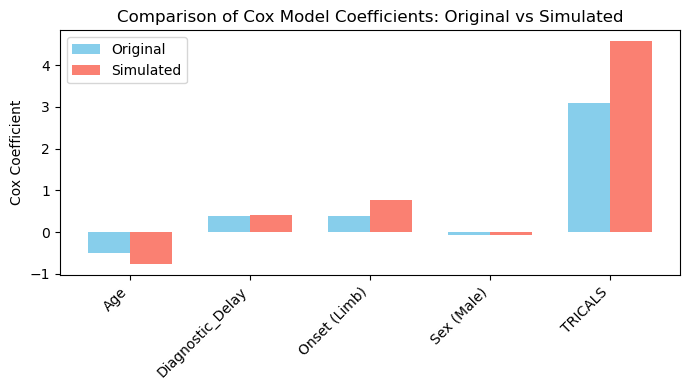

In [1351]:
# Fit Cox on simulated data
cph_sim = CoxPHFitter()
cph_sim.fit(simtrain_df, duration_col="median_survival_time", event_col="event")

# Extract coefficients
coeff_orig = cph.params_
coeff_sim = cph_sim.params_

# Align indices (covariates) in case of any mismatch
common_idx = coeff_orig.index.intersection(coeff_sim.index)
coeff_orig = coeff_orig[common_idx]
coeff_sim = coeff_sim[common_idx]

# Plot
x = np.arange(len(common_idx))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width/2, coeff_orig.values, width, label='Original', color='skyblue')
ax.bar(x + width/2, coeff_sim.values, width, label='Simulated', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(common_idx, rotation=45, ha='right')
ax.set_ylabel('Cox Coefficient')
ax.set_title('Comparison of Cox Model Coefficients: Original vs Simulated')
ax.legend()
plt.tight_layout()
plt.show()

In [736]:
# coeff_sim

##### 5. Optional: Compare survival curves stratified by covariates

In [737]:
# for group in train_df['Sexx_Male'].unique():
#     km_orig.fit(train_df.loc[train_df['Sexx_Male']==group, 'Disease_Duration'],
#                 event_observed=train_df.loc[train_df['Sexx_Male']==group, 'Event'], label=f'Original-{group}')
#     km_sim.fit(sim_df.loc[sim_df['Sexx_Male']==group, 'Disease_DurationM'],
#                event_observed=sim_df.loc[sim_df['Sexx_Male']==group, 'Event'], label=f'Simulated-{group}')
#     plt.figure()
#     km_orig.plot()
#     km_sim.plot()
#     plt.title(f'Survival by Sexx_Male={group}')
#     plt.grid(True)
#     plt.show()

##### Compare survival distributions of original active and original placebo

In [738]:
df_pla = df_onehot[df_onehot['Study_Arm'] == 'Placebo']
df_act = df_onehot[df_onehot['Study_Arm'] == 'Active']

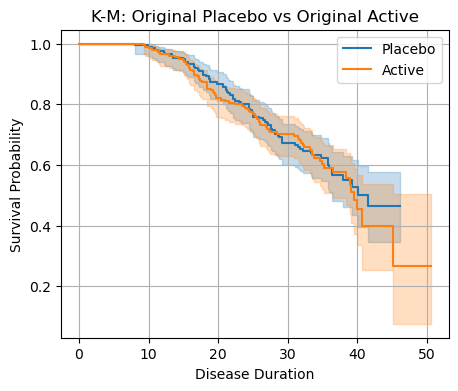

In [739]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(df_pla['Disease_Duration'], event_observed=df_pla['Event'], label='Placebo')

# Simulated data
km_sim = KaplanMeierFitter()
km_sim.fit(df_act['Disease_Duration'], event_observed=df_act['Event'], label='Active')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim.plot()
plt.title('K-M: Original Placebo vs Original Active')
plt.xlabel('Disease Duration')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


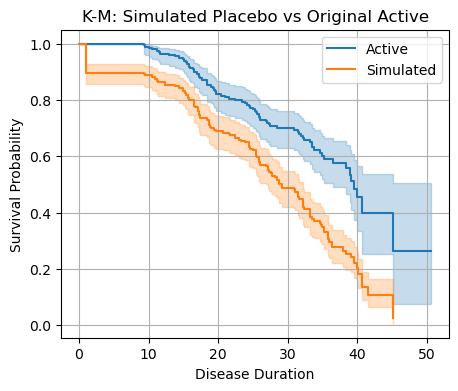

In [740]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(df_act['Disease_Duration'], event_observed=df_act['Event'], label='Active')

# Simulated data
km_sim = KaplanMeierFitter()
km_sim.fit(sim_onehot['median_survival_time'], event_observed=sim_onehot['event'], label='Simulated')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim.plot()
plt.title('K-M: Simulated Placebo vs Original Active')
plt.xlabel('Disease Duration')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [741]:
train_df.columns
betas.index

Index(['Age', 'Diagnostic_Delay', 'Onset (Limb)', 'Sex (Male)', 'TRICALS'], dtype='object', name='covariate')

In [805]:
# miro.isna().sum()